In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
import cartopy.crs as ccrs
from tqdm import tqdm
from shapely import Point, LineString, Polygon
import numpy as np
from itertools import product
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [3]:
# quarter meridian
qm = 10_001_965.729
# poles of inaccessibility (from wikipedia)
actual_poles = gpd.GeoDataFrame({'pole':['original','EPIA1','EPIA2'],
                                 'distance':[2645,2510,2514],
                                 'error':[np.nan,10,7],
                                 'geometry':[Point(86+40/60, 46+17/60),
                                             Point(82.19,44.29),
                                             Point(88.14,45.28)]},
                                crs=4326)

In [4]:
### some helper functions
#.
# make circle, of radius d, centrered on 0,0,
# create square grid of num x num points (with radius d) then clip to the circle
# project to the speciifed aziumuth equidistant project (aeqd)
def make_circle_and_points(d, aeqd, num=20):
    circle = Point(0,0).buffer(d)
    minx,miny,maxx,maxy = circle.bounds
    x_points = np.linspace(minx,maxx,num)
    y_points = np.linspace(miny,maxy,num)

    points = gpd.GeoDataFrame(geometry=[Point(p) for p in product(x_points,y_points)], crs=aeqd).clip(circle)
    points['distance_to_centroid'] = points.distance(Point(0,0))
    points = points.sort_values(by='distance_to_centroid', ascending=True).reset_index(drop=True)

    # reproject and get lat lon coordinates of each point
    points_4326 = points.to_crs(4326)
    points_4326['lon'] = points_4326['geometry'].x
    points_4326['lat'] = points_4326['geometry'].y

    # then join with the points dataframe
    points = points.merge(points_4326[['lon','lat']],
                        left_index=True, right_index=True)

    points['proj4'] = points.apply(lambda row: f'+proj=aeqd +lon_0={row["lon"]} +lat_0={row["lat"]} +ellps=WGS84 +units=m +no_defs', axis=1)
    
    return points

### gets distance from from origin of crs defined by proj4 to edge of polygon
def distance_to_boundary(proj4,poly_4326):
    '''
    # for each of these points, construct a new coordinates system centered on it...
    # reproject thepolygon to this coordinate system
    # get distance to boundary
    # there is probably a quicker way than this...but it takes ~24 seconds for 276 rows...and i think that is ok
    '''
    new_aeqd = CRS.from_proj4(proj4)
    rprj_poly = poly_4326.to_crs(new_aeqd)
    d = rprj_poly.geometry[0].exterior.distance(Point(0,0))
    
    return d/1000 # to put it in km

In [5]:
## read in data, convert to 
world = gpd.read_file('../day3_polygons/ne_10m_admin_0_countries.zip')

hobo_dyer = CRS.from_proj4('+proj=cea +lon_0=0 +lat_ts=37.5 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs')
world_dissolved_singlepart = world.dissolve().explode(index_parts=True).reset_index(drop=True)
world_hd = world_dissolved_singlepart.to_crs(hobo_dyer)
world_hd['area'] = world_hd.area
thepolygon = world_dissolved_singlepart.loc[world_hd['area'].idxmax(),'geometry']
thepolygon_4326 = gpd.GeoSeries(thepolygon,crs=4326)


c:\Users\s1759665\Miniconda3\envs\shadow\Lib\site-packages\geopandas\geodataframe.py:1922: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[exploded_geom.name] = exploded_geom.values


distance from "centroid" to nearest point on boundary: 1253.082 km


C:\Users\s1759665\AppData\Local\Temp\ipykernel_12096\807883177.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=8)


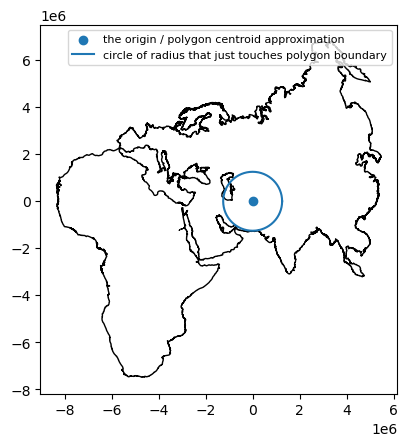

In [11]:
## set up for first run

# largest area, is hereafter referred to as thepolygon
#crudely estimating centroid in geographic coordinates
# which will be wrong...because geographci coordinates
# and this will give a warning
x0 = thepolygon.centroid.x
y0 = thepolygon.centroid.y
centroid = Point(x0,y0)

# construct an azimuthal equidistant projection centered on the approximate 'centroid'
# the centroid will have coordinates, (0,0) in this projection
aeqd = CRS.from_proj4(f'+proj=aeqd +lon_0={x0} +lat_0={y0} +ellps=WGS84 +units=m +no_defs')

### quick plot to check that that looks about right
# ax=world.to_crs(aeqd).plot(figsize=[2,2], fc='none')
# ax.scatter(0,0)
# ax.set_axis_off()

## calculate the distance from this 'centroid' to the edge of thepolygon:
# first reproject it:
rprj_poly = thepolygon_4326.to_crs(aeqd)

# get distance to boundary:
d = rprj_poly.geometry[0].exterior.distance(Point(0,0))
print(f'distance from "centroid" to nearest point on boundary: {np.round(d/1000,3)} km')

ax = rprj_poly.plot(fc='none', ec='k', label='the polygon')
ax.scatter(0,0, label='the origin / polygon centroid approximation')
ax.plot(*Point(0,0).buffer(d).exterior.coords.xy, label='circle of radius that just touches polygon boundary')
ax.legend(fontsize=8)

  0%|          | 0/4 [00:00<?, ?it/s]

current search diameter: 3000000
current best estimate:
lon                       80.119269
lat                       43.957534
distance_to_boundary    2383.629255
Name: 3, dtype: object


 25%|██▌       | 1/4 [00:38<01:54, 38.31s/it]

current search diameter: 893187.5130777444
current best estimate:
lon                       82.064835
lat                       44.772646
distance_to_boundary    2464.265916
Name: 25, dtype: object


 50%|█████     | 2/4 [02:23<02:35, 77.78s/it]

current search diameter: 184797.4164988437
current best estimate:
lon                       81.170259
lat                       44.555933
distance_to_boundary    2475.381191
Name: 202, dtype: object


 75%|███████▌  | 3/4 [05:14<02:00, 120.46s/it]

current search diameter: 48322.340143032685
current best estimate:
lon                      81.058602
lat                      44.529254
distance_to_boundary    2476.71982
Name: 72, dtype: object


 75%|███████▌  | 3/4 [09:55<03:18, 198.55s/it]


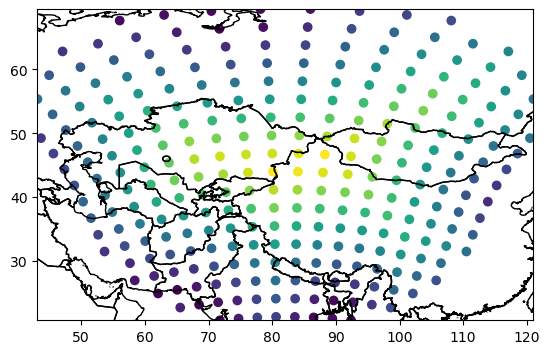

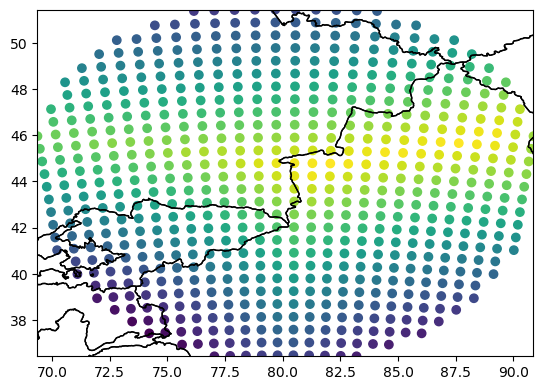

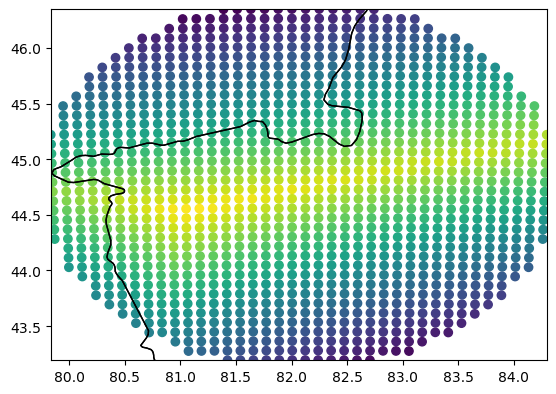

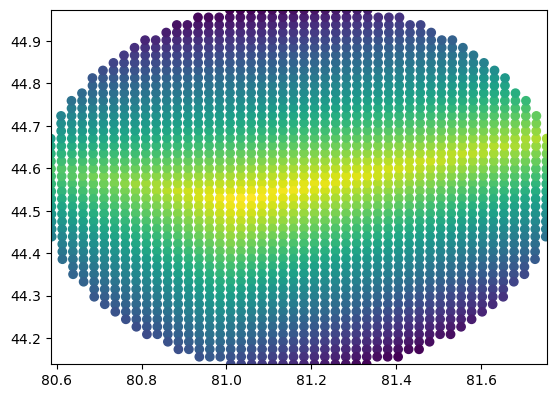

In [13]:
d = 3000_000
for i in tqdm(range(4)):
    num=10+10*(i+1)
    print(f'current search diameter: {d}')
    points = make_circle_and_points(d=d, aeqd=aeqd, num=num)
    points['distance_to_boundary'] = points.apply(lambda row: distance_to_boundary(row['proj4'], thepolygon_4326), axis=1)
    
    idx_max = points['distance_to_boundary'].idxmax()
    print(f"current best estimate:\n{points.loc[idx_max, ['lon','lat','distance_to_boundary']]}")

    # get new aeqd projection
    aeqd = CRS.from_proj4(points.loc[points['distance_to_boundary'].idxmax(),'proj4'])

    # get difference between the current furtherst and the n-th furthest away (either 2nd, 3rd... or 5th)
    d = points.loc[idx_max,'geometry'].distance(
        points.loc[points['distance_to_boundary'].nlargest(15).index[-1],'geometry']
        )
    
    fig, ax = plt.subplots()
    points.to_crs(4326).plot(column='distance_to_boundary',ax=ax)
    world.plot(fc='none',ax=ax)
    minx,miny,maxx,maxy = points.to_crs(4326).total_bounds
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    
    if d < 10_000:
        break

In [14]:
## my calculated point of inaccessibility (poi)
poi = gpd.GeoDataFrame([points.loc[points['distance_to_boundary'].idxmax()]])

print('my generated poi is this far (km) from previously established points...\n')
print(actual_poles.set_index('pole').to_crs(points.crs)['geometry'].distance(points.loc[points['distance_to_boundary'].idxmax(),'geometry'])/1000)
print(f"\nand at this point ({np.round(poi['lat'].values[0],2)} N,{np.round(poi['lon'].values[0],2)} E) it is {np.round((poi['distance_to_boundary'].values[0]),1)} km from the sea")

my generated poi is this far (km) from previously established points...

pole
original    480.232027
EPIA1        93.957301
EPIA2       565.268649
dtype: float64

and at this point (44.53 N,81.06 E) it is 2476.7 km from the sea


In [15]:
# final projection centered on my poi
projection = CRS.from_proj4(poi['proj4'].values[0])

## using cartopy for compatibility with matplotlib
final_proj = ccrs.AzimuthalEquidistant(central_latitude=poi['lat'].values[0],
                                       central_longitude=poi['lon'].values[0])

quarter_meridian_away = gpd.GeoSeries(Point(0,0).buffer(qm),crs=final_proj)

## clip the world
world_clipped = (world.explode(index_parts=False)
                 .to_crs(projection)
                 .clip(quarter_meridian_away))


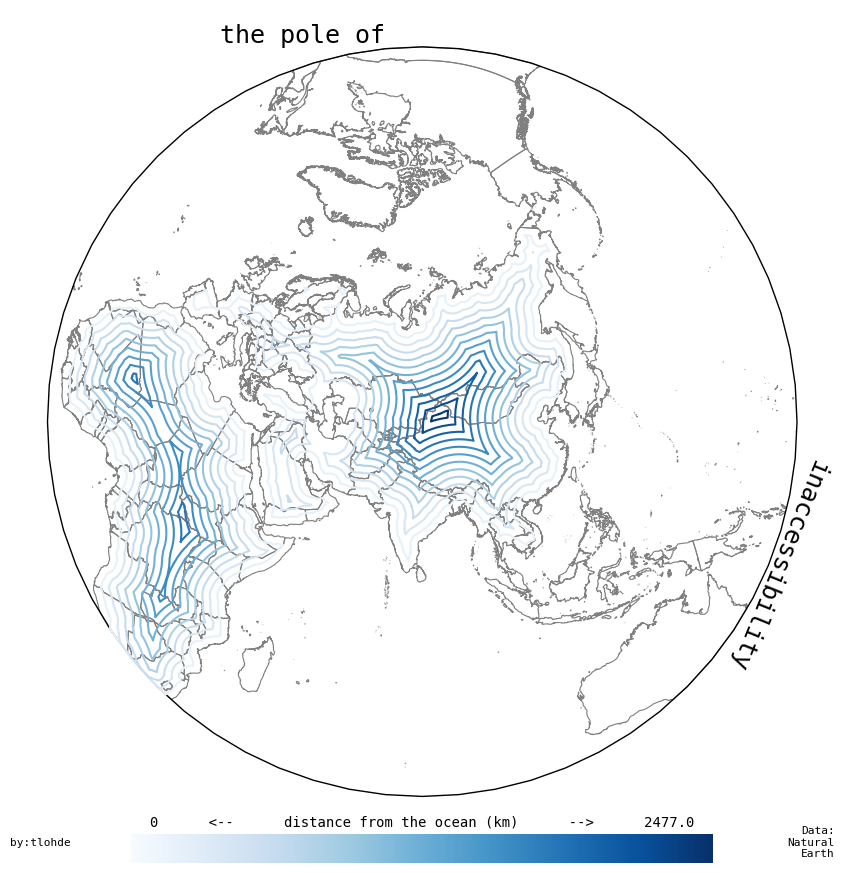

In [72]:
fig,ax=plt.subplots(subplot_kw={'projection':final_proj},
                    figsize=[10,10])

world_clipped.plot(ax=ax,
                   fc='none', ec='grey',
                   linewidth=0.8)


cmap = plt.cm.Blues
norm = Normalize(vmin=0, vmax=poi['distance_to_boundary'])

for val in np.arange(200,2600,200):
    contour = thepolygon_4326.to_crs(projection).values[0].buffer(val*-1e3)
    contour = gpd.GeoSeries(contour,crs=projection).clip(quarter_meridian_away)[0]
    if contour.geom_type == 'MultiPolygon':
        for geom in contour.geoms:
            ax.plot(*geom.exterior.coords.xy, c=cmap(norm(val)))
    else:
        ax.plot(*contour.exterior.coords.xy, c=cmap(norm(val)))

quarter_meridian_away.plot(ax=ax, ec='k', fc='none')

ax.set_axis_off()

cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='bottom', shrink=0.6, pad=0)
cb.ax.set_axis_off()
cb.ax.set_title(f'0      <--      distance from the ocean (km)      -->      {np.round((poi["distance_to_boundary"].values[0]))}', font='DejaVu Sans Mono')

ax.annotate(text='Data:\nNatural\nEarth',
            xy=(1,-0.01), xycoords='axes fraction', ha='right', va='center', fontsize=8, font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0,-0.01), xycoords='axes fraction', fontsize=8, va='center', font='DejaVu Sans Mono')

ax.set_title('the pole of                ', y=0.95, font='DejaVu Sans Mono', **{'fontsize':18})
ax.annotate(text='inaccessibility',
            xy=(0.865,0.2), xycoords='axes fraction', fontsize=18, font='DejaVu Sans Mono', rotation=-112)

plt.tight_layout()

In [73]:
fig.savefig('day6.png', bbox_inches='tight', dpi=300)